In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = anndata.read("../../data/cheng21_cell_scrna/organized/P28NR.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 23930 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [3]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [4]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [5]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [6]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)

ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [7]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]
# res['type'] = types

Text(0, 0.5, 'explained var')

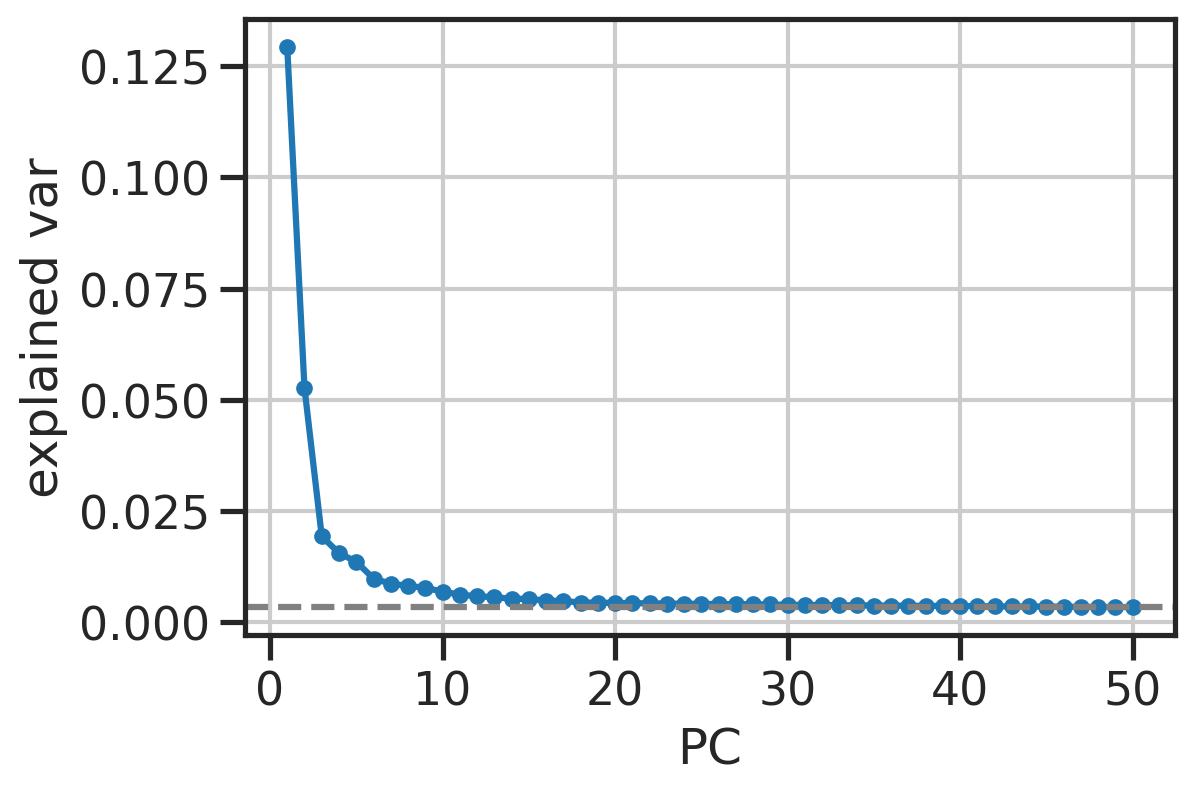

In [8]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

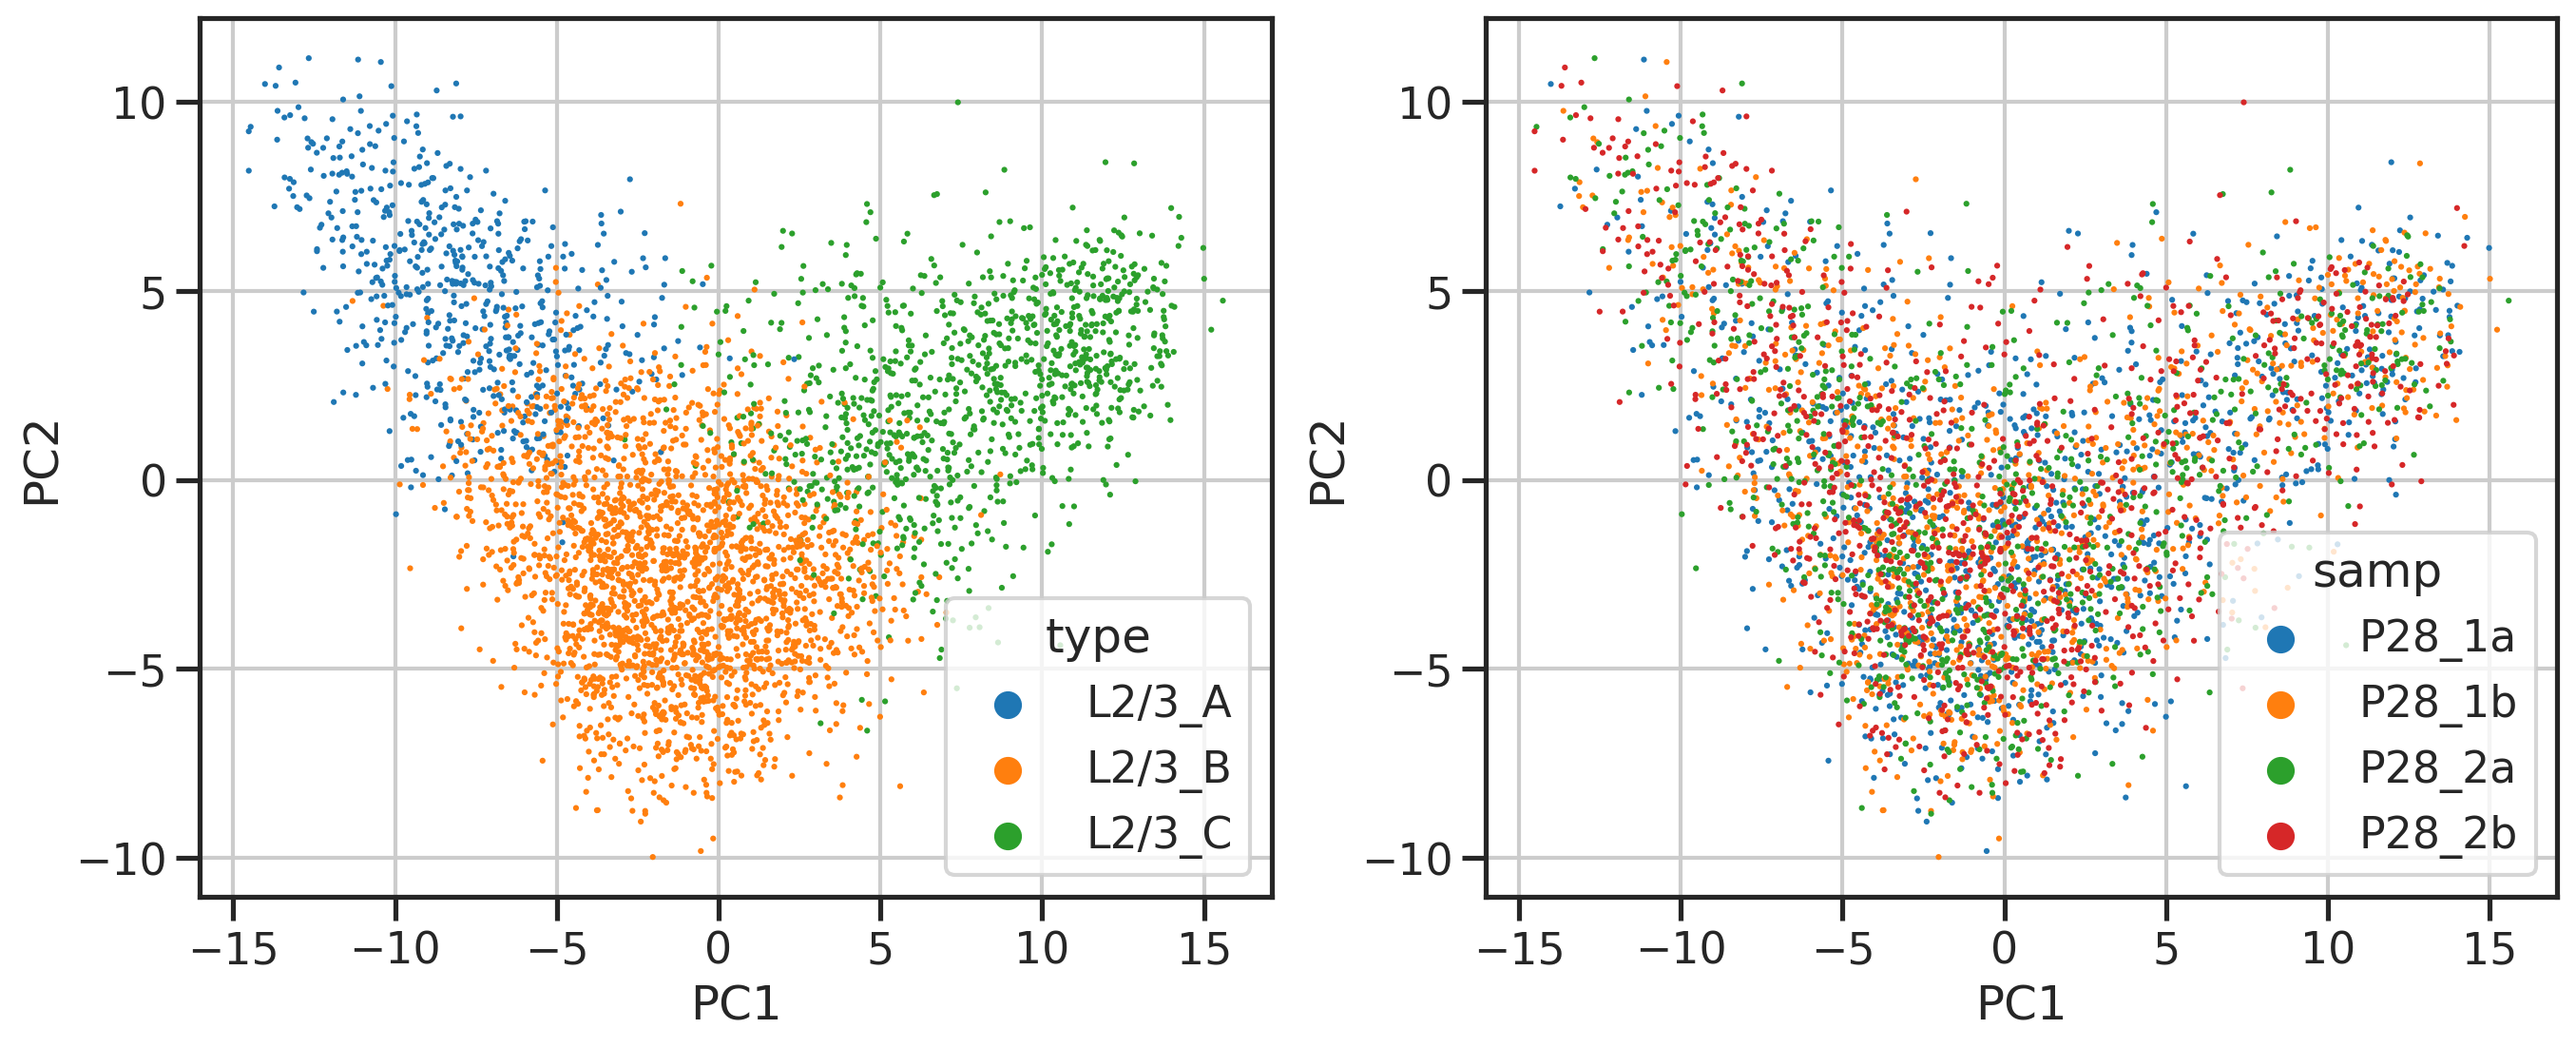

In [9]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

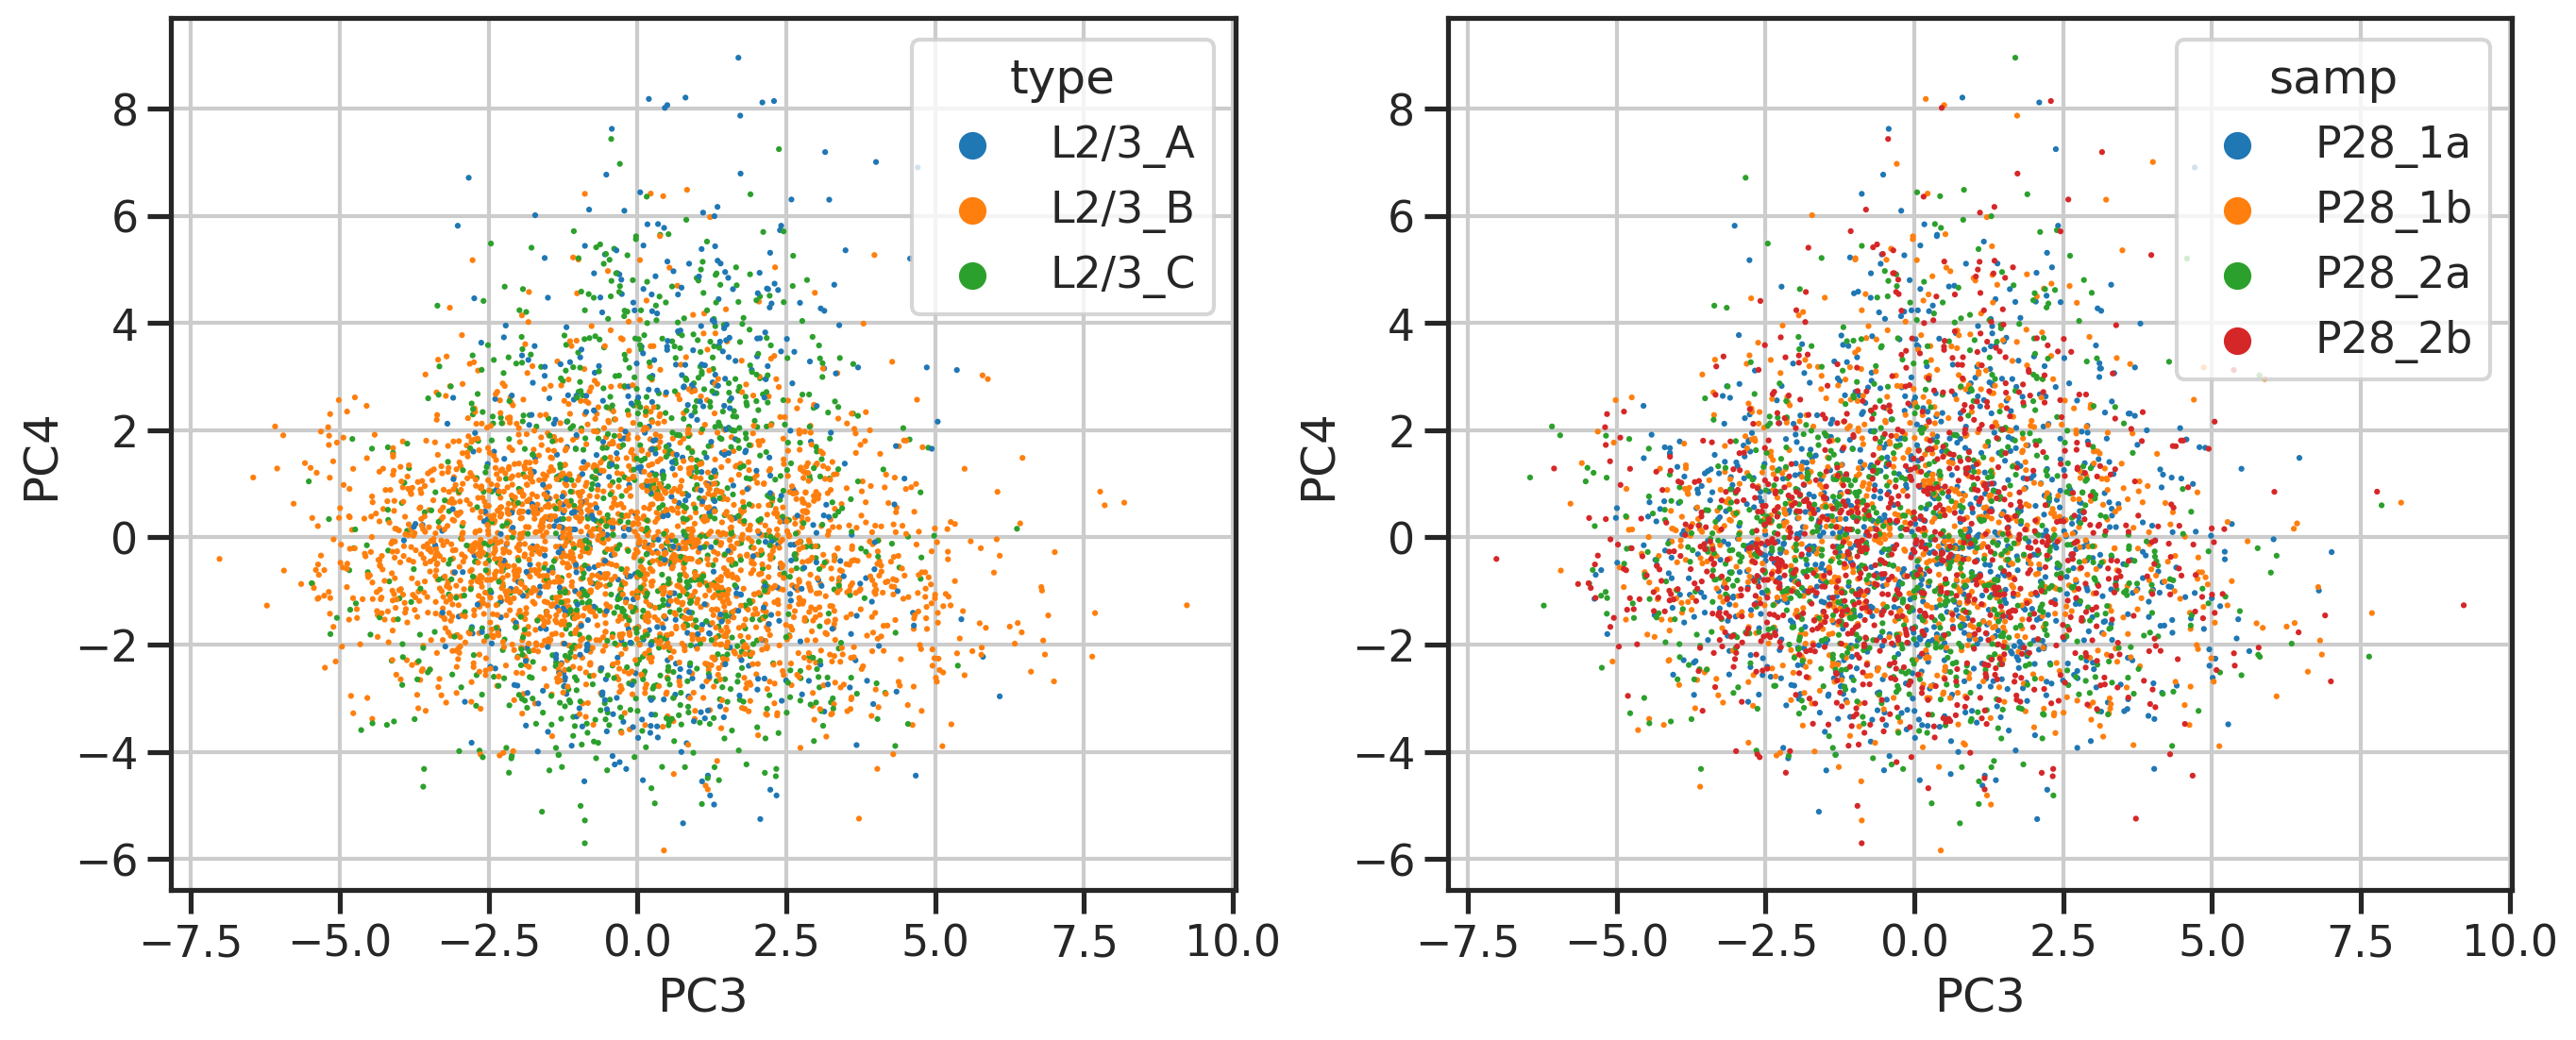

In [10]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

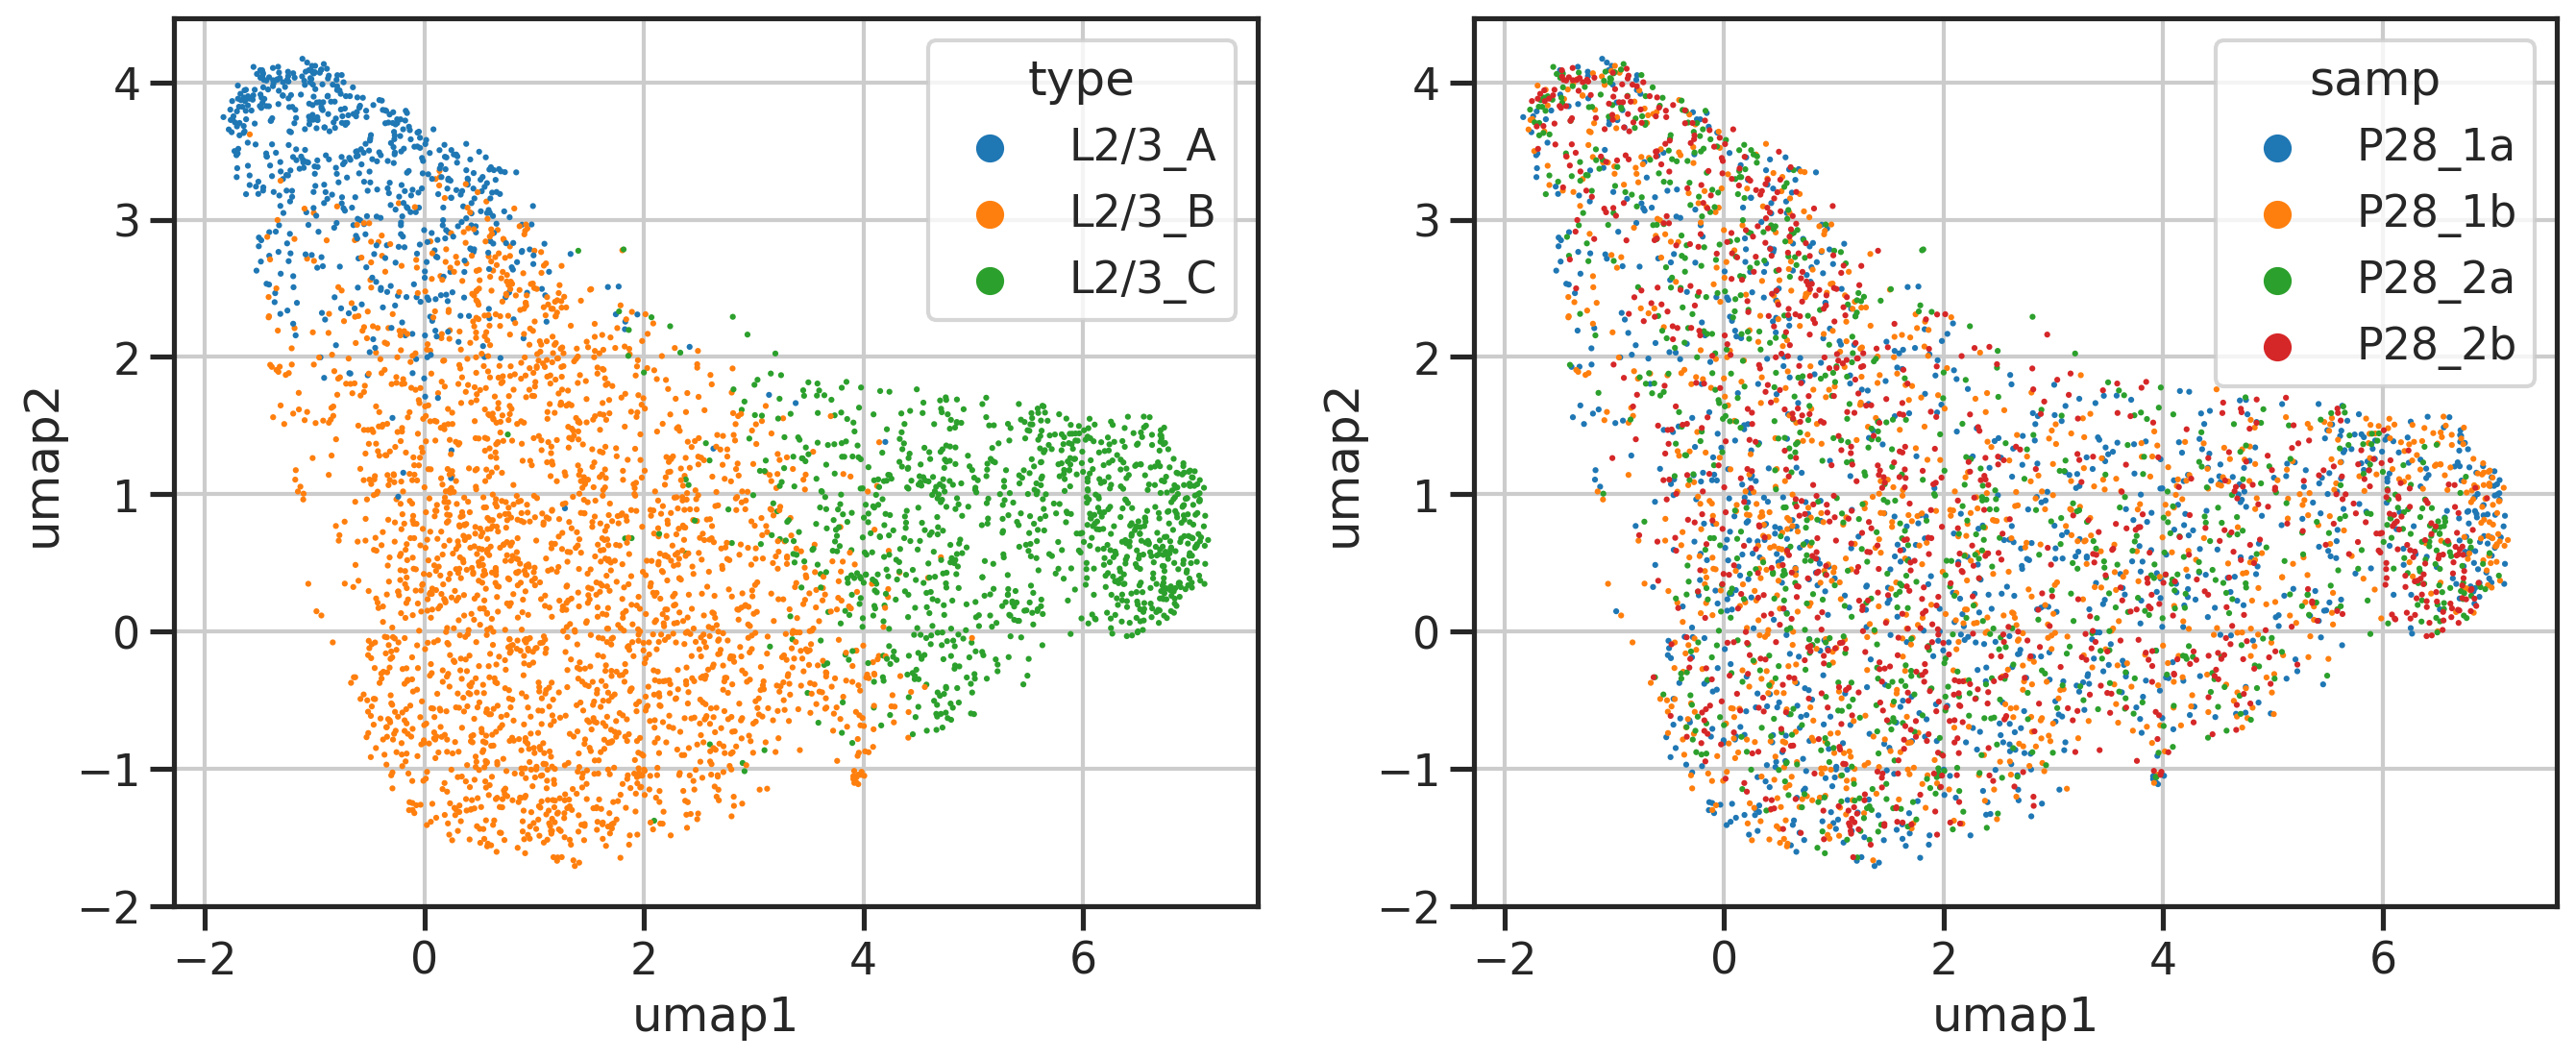

In [11]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [12]:
rowidx = basicu.order_by_hc(zlognorm)
# colidx = basicu.order_by_hc(zlognorm.T)

In [13]:
my_colors = ('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = ('C0', 'C1', 'C2', 'C3')
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

In [14]:
ncell, ngene = zlognorm.shape

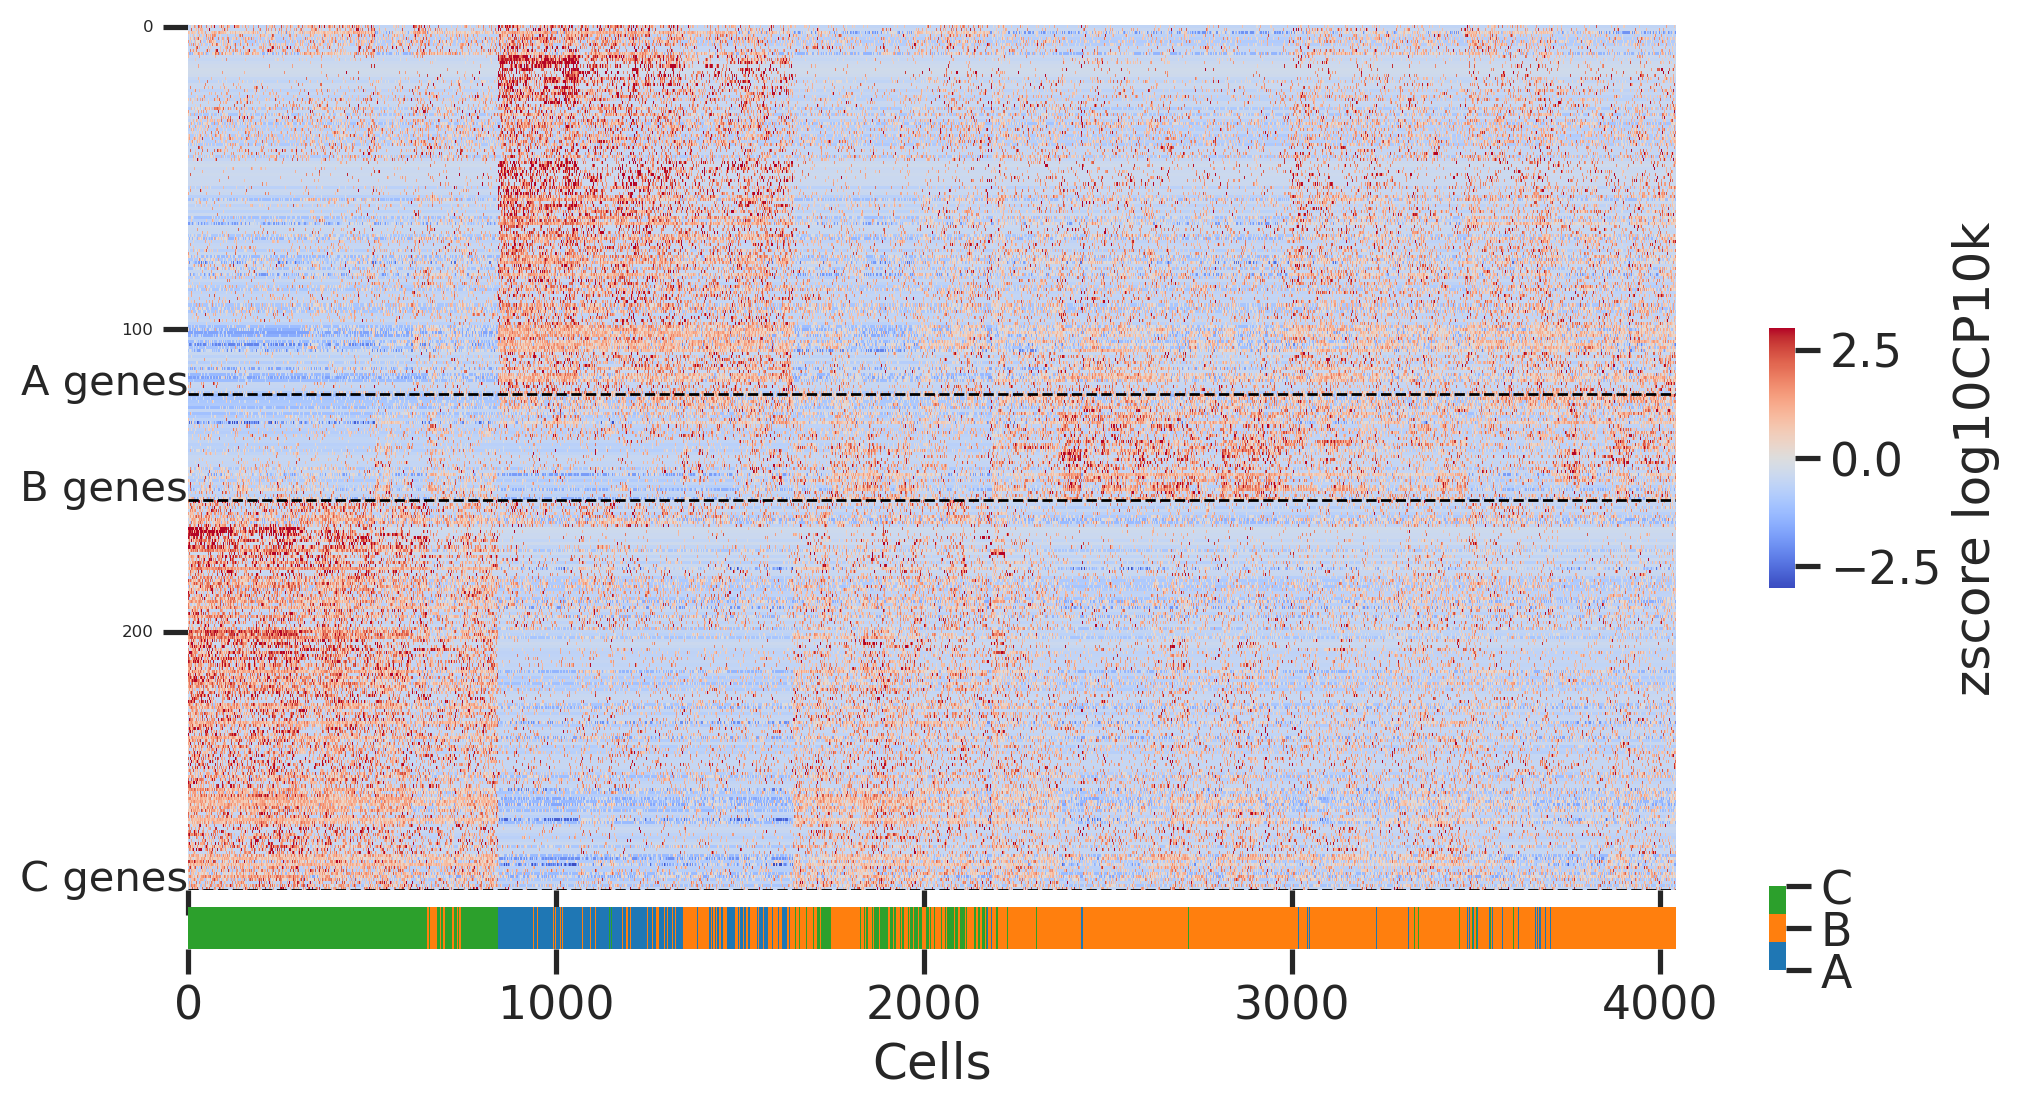

In [15]:
fig, axdict = plt.subplot_mosaic("A\n"*15+"B", figsize=(12,6), sharex=True)
ax = axdict['A']
sns.heatmap(zlognorm[rowidx].T,
            xticklabels=1000,
            yticklabels=100,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            ax=ax,
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

ax.hlines(np.cumsum(gene_type_counts), 0, ncell, linewidth=1, linestyle='--', color='k')
for y, lbl in zip(np.cumsum(gene_type_counts), ['A genes', 'B genes', 'C genes']):
    ax.text(0, y, lbl, fontsize=15, ha='right')

ax = axdict['B']
sns.heatmap(pd.factorize(types[rowidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])

fig.subplots_adjust(hspace=0.4)
plt.show()

# give each cell a pseudo-time index

In [16]:
adata.obsm['X_pca'] = pcs

In [17]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
# adata.uns['iroot'] = np.flatnonzero(adata.obs['Type']=='L2/3_A')[0]
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
adata

AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass', 'dpt_pseudotime'
    uns: 'neighbors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [18]:
adata.obsm['X_diffmap'].shape

(4044, 15)

In [19]:
res['ptime'] = adata.obs['dpt_pseudotime'].values

# check pseudotime (and diff map)

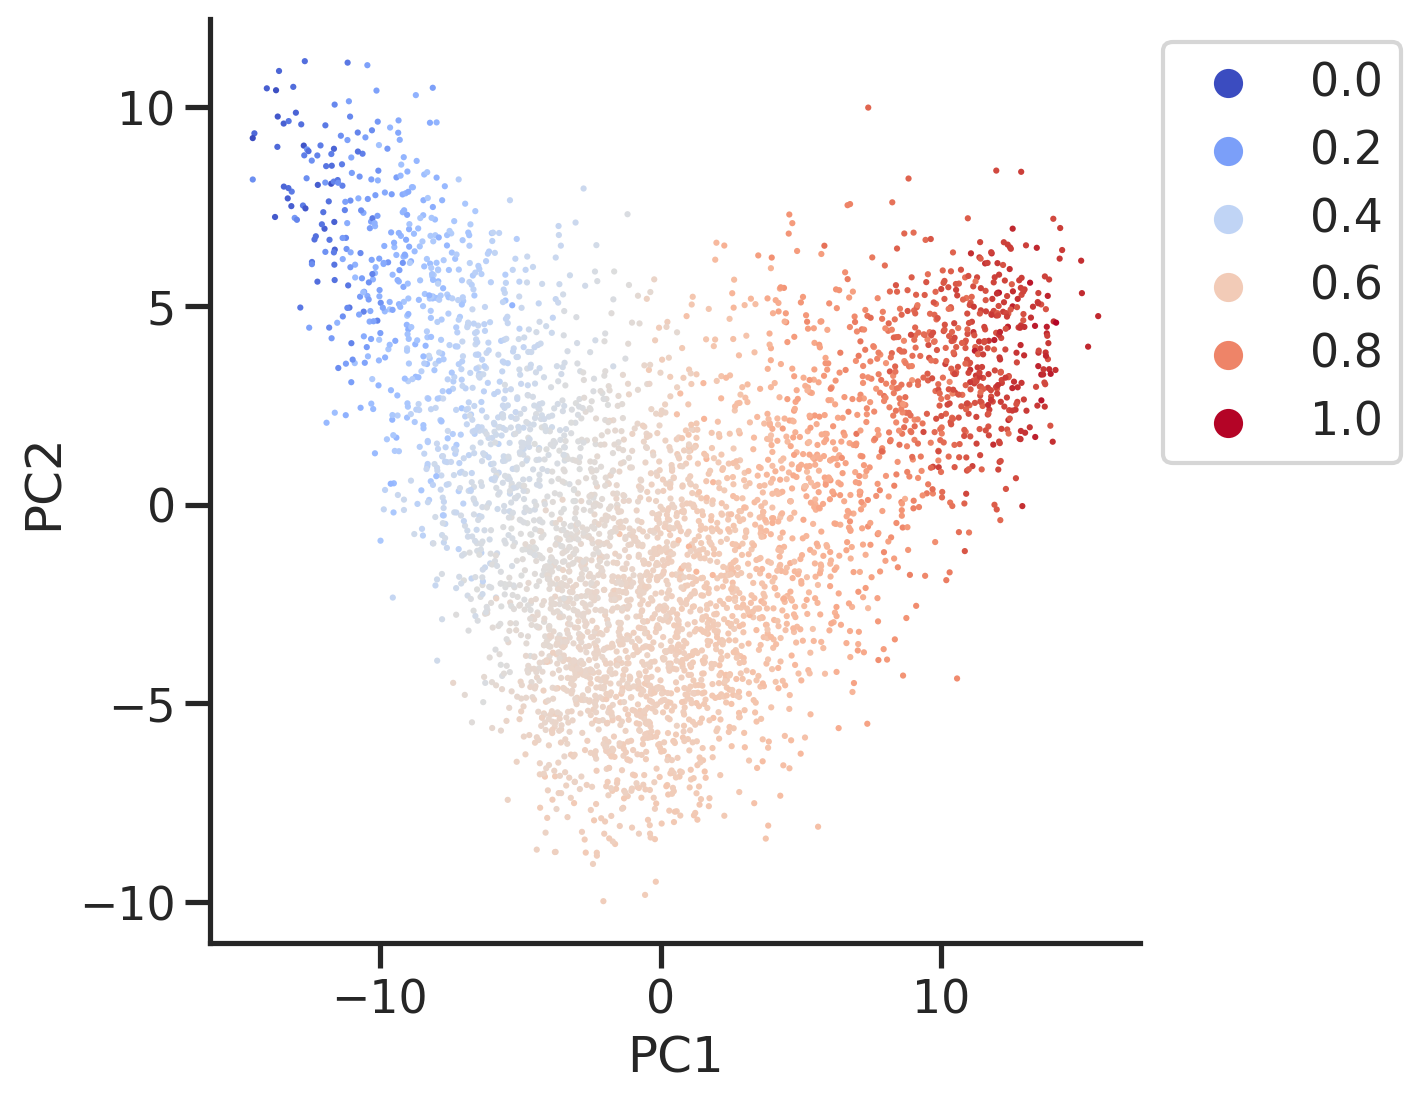

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-27 10:58:33 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


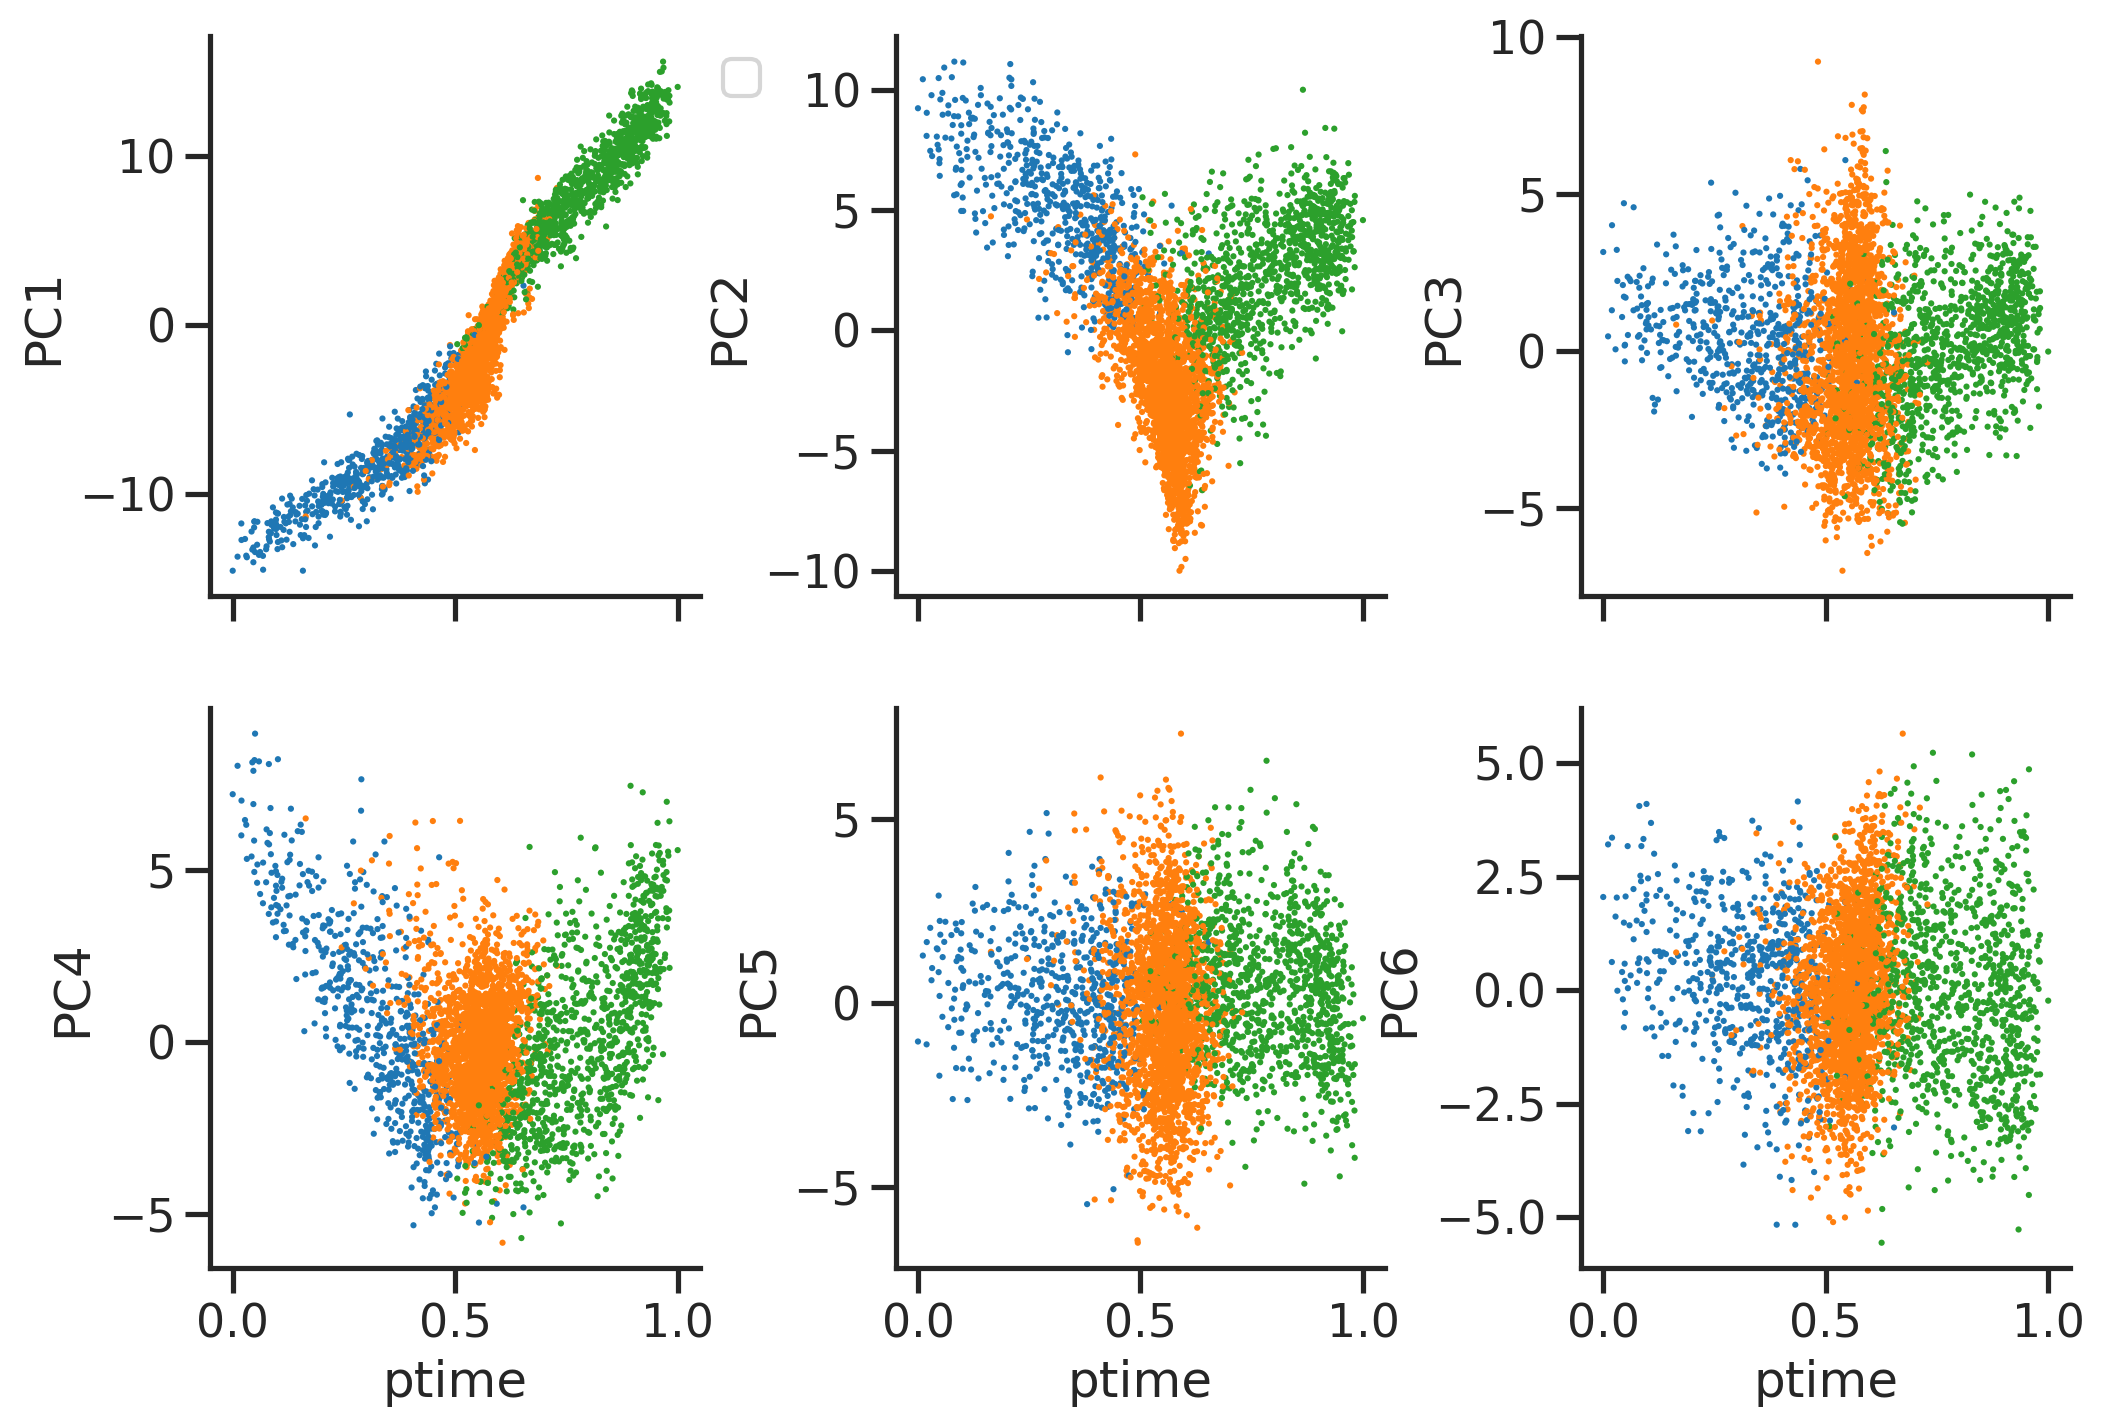

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

In [22]:
cellidx = np.argsort(res['ptime'].values)

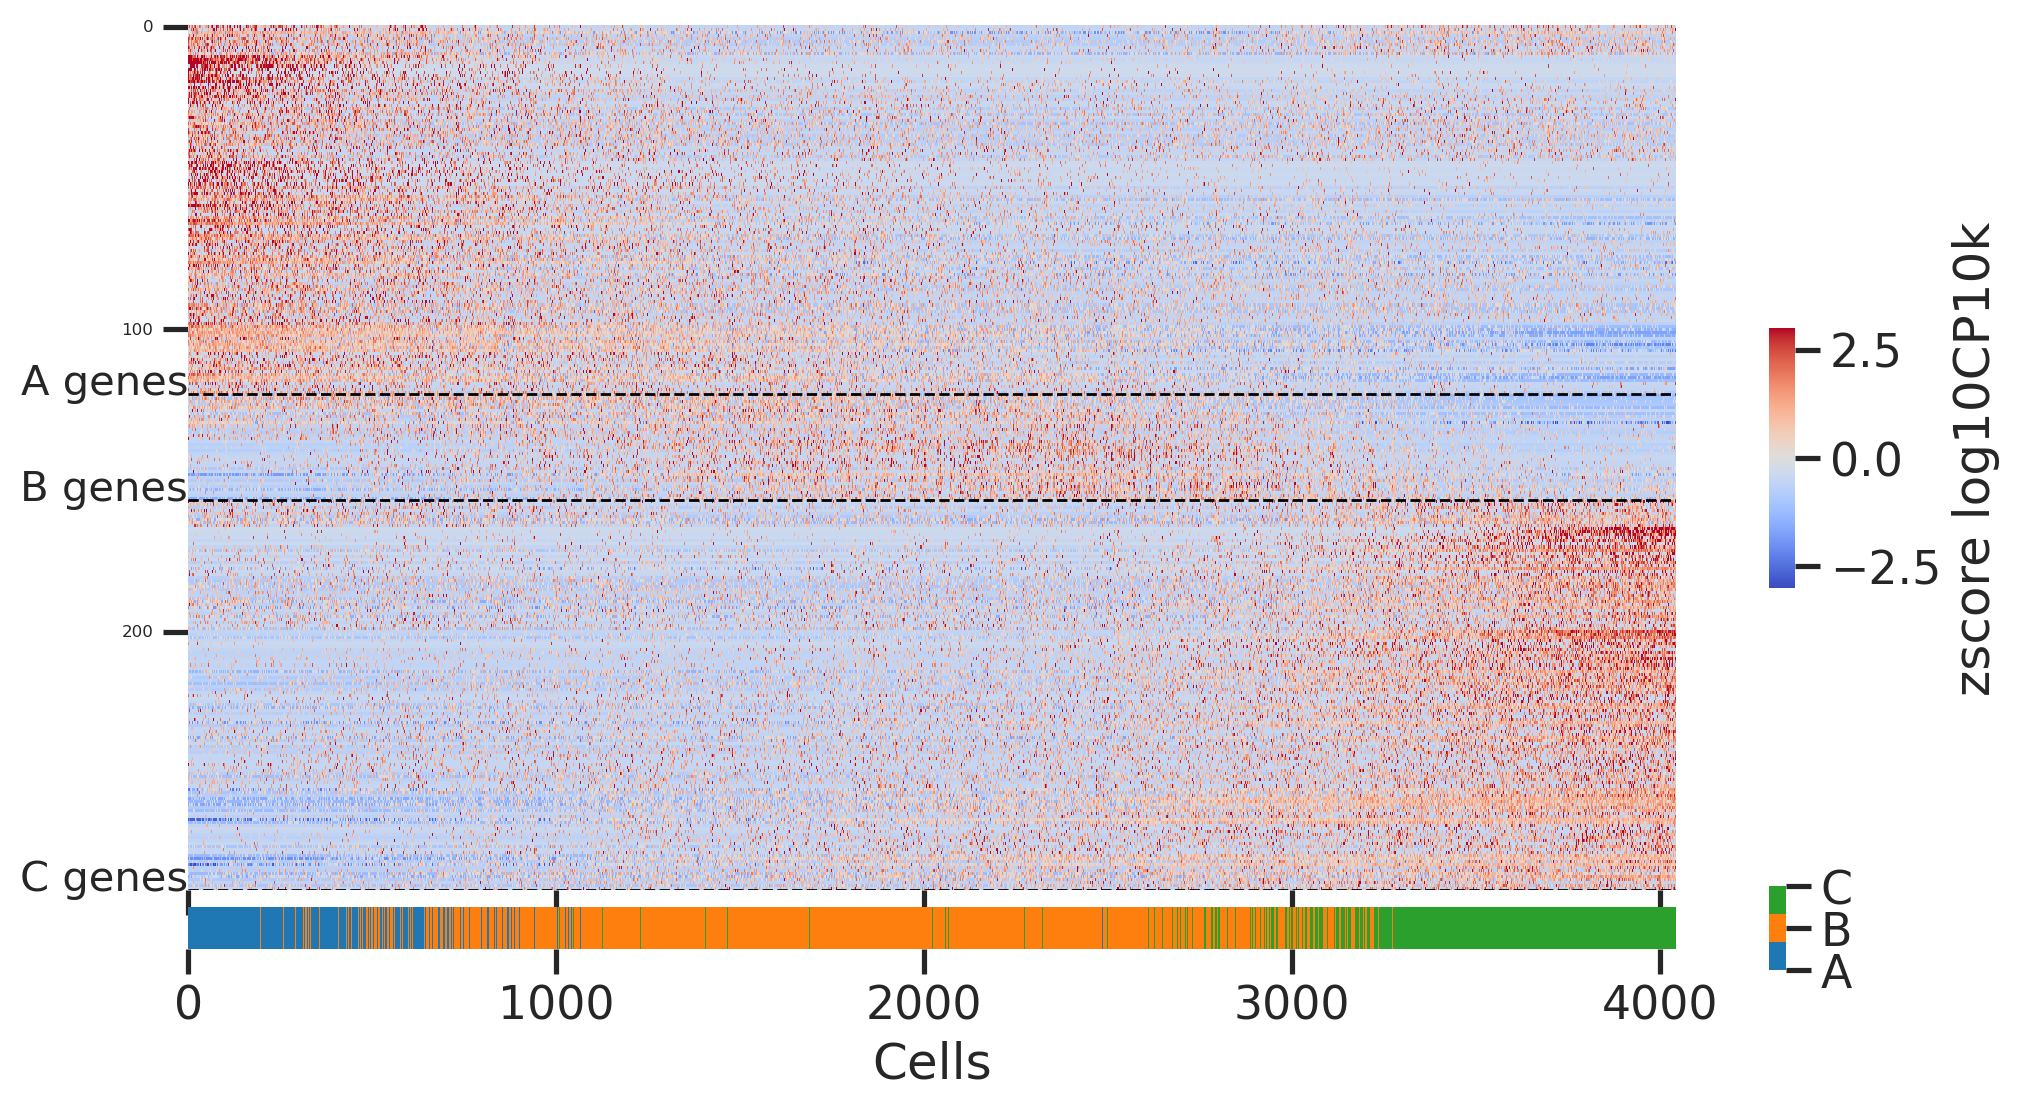

In [23]:
fig, axdict = plt.subplot_mosaic("A\n"*15+"B", figsize=(12,6), sharex=True)
ax = axdict['A']
sns.heatmap(zlognorm[cellidx].T,
            xticklabels=1000,
            yticklabels=100,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            ax=ax,
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

ax.hlines(np.cumsum(gene_type_counts), 0, ncell, linewidth=1, linestyle='--', color='k')
for y, lbl in zip(np.cumsum(gene_type_counts), ['A genes', 'B genes', 'C genes']):
    ax.text(0, y, lbl, fontsize=15, ha='right')

ax = axdict['B']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])

fig.subplots_adjust(hspace=0.4)
plt.show()

# Give each gene a pseudo time too
- assign each gene a ptime as the weighted average of cell ptime

In [24]:
weights = (lognorm/lognorm.sum(axis=0))
gptime  = res['ptime'].values.dot(weights)
geneidx = np.argsort(gptime)

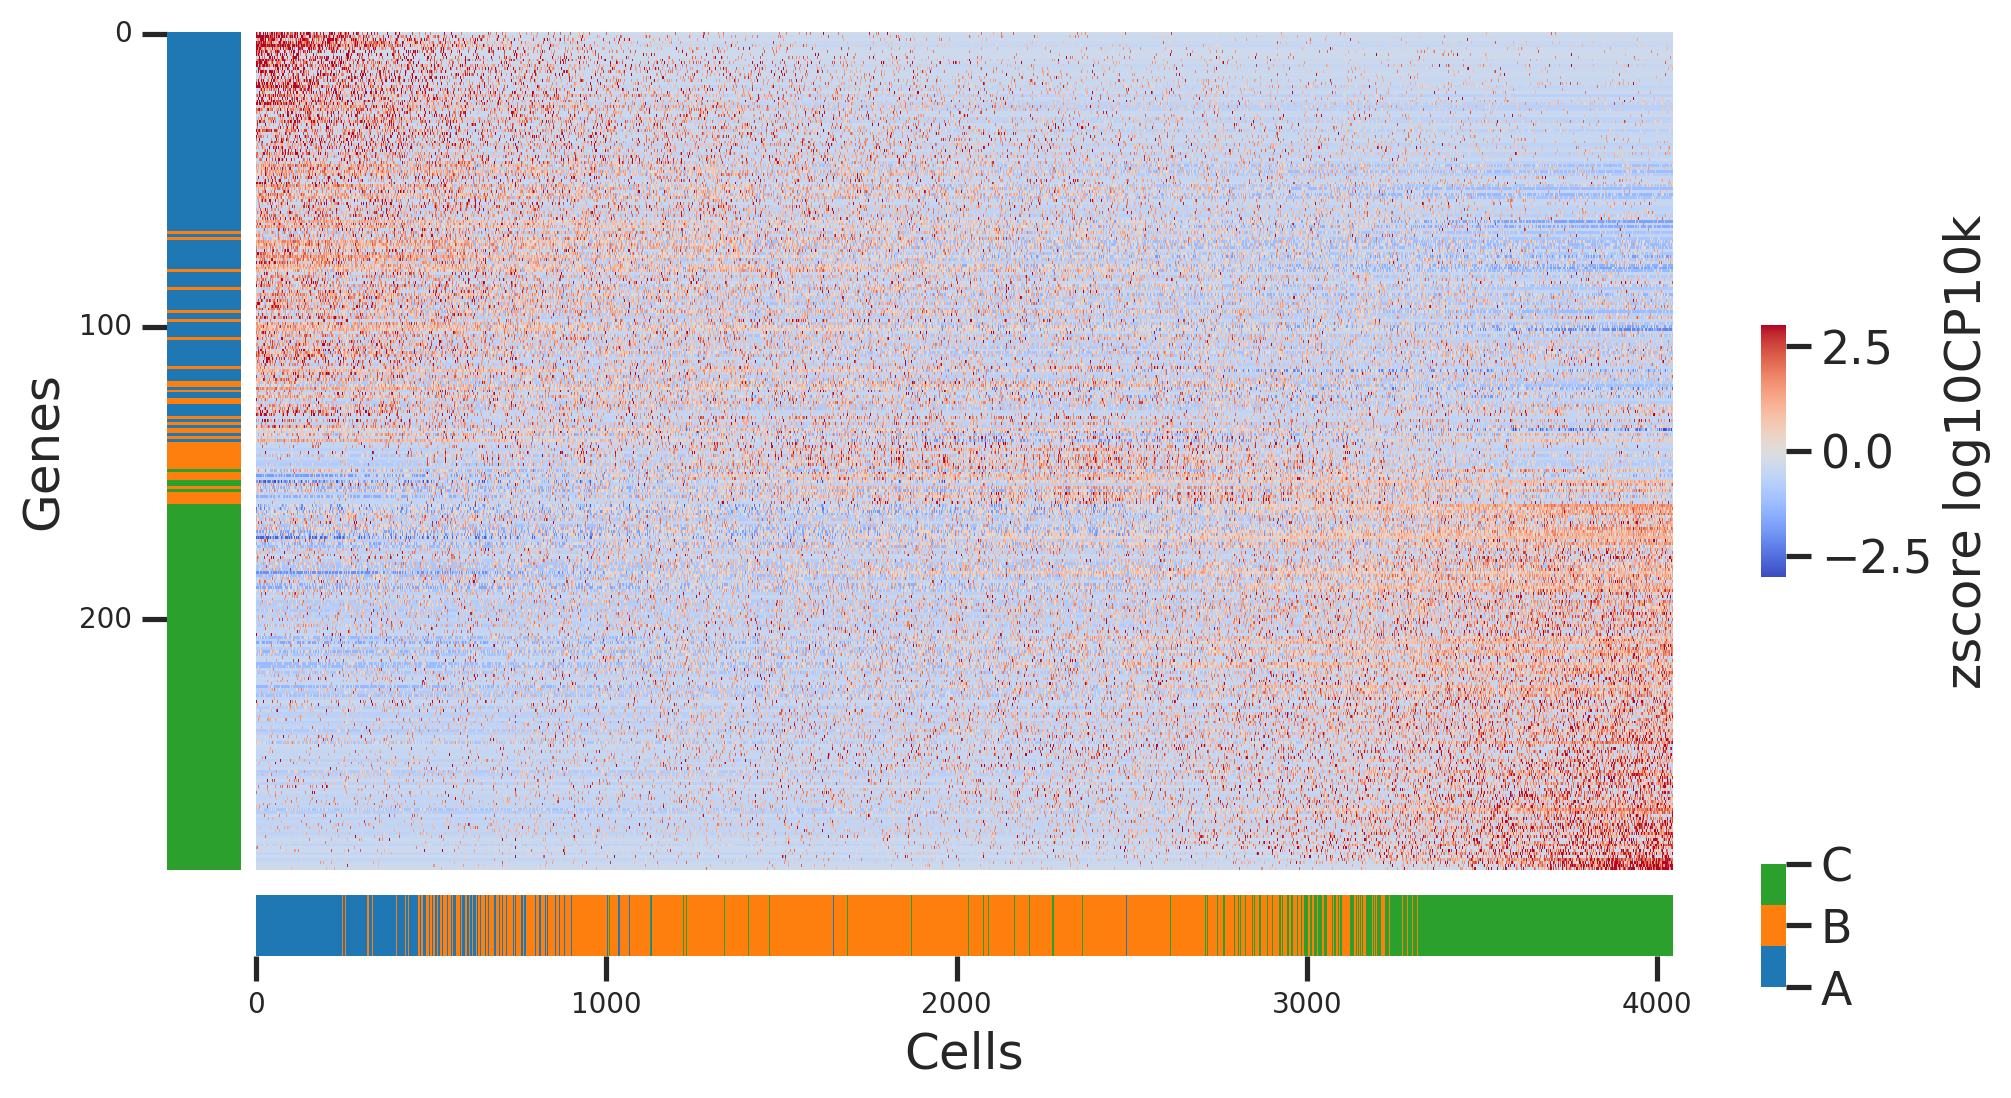

In [25]:
mosaic = ("B"+"A"*20+"\n")*10 + "."+"C"*20
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,6))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            ax=ax,
           )

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_yticklabels(['A','B','C'])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.4)
plt.show()

# Save this result:
- P28 cell ptime and gene ptime

In [26]:
res

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      1.146153  5.233578 -2.200268 -3.925078 -0.108609  1.057919  2.098608   
1     -0.518836 -6.410185  1.400244  0.050016 -0.775864 -3.161404 -0.393452   
2      3.927249  3.636209 -1.234445 -2.778796 -0.598687 -0.842251 -0.366045   
3     11.051389  6.327117  2.315020  1.078655 -1.124618 -2.484066  1.593738   
4     -3.685995 -2.021657 -0.268078 -2.175095  0.278732 -1.557738  0.989613   
...         ...       ...       ...       ...       ...       ...       ...   
4039  -6.097853 -2.068518 -1.281546  1.155488 -1.470428  0.543350  0.459320   
4040  -3.879922  0.587725  1.844694 -2.056178  1.109316 -1.981575 -1.651621   
4041   1.520208 -1.121181 -0.980249 -1.056145  0.382915 -2.007612 -1.416520   
4042   0.086318 -1.396959  2.496196 -1.631318 -0.718756  1.145641 -1.365138   
4043  -4.506055 -4.132812  0.455711 -0.313236  0.460151  0.374142 -0.836315   

           PC8       PC9      PC10  ...      PC46      PC47      PC48  \
0    -0.046825  1.041885 -0.391098  ...  0.029585  0.228152  0.816676   
1    -1.495165  0.116605  1.937810  ... -0.664346  2.115774  0.466613   
2    -0.555947 -0.303961  0.004756  ... -1.410287  0.813803  0.739597   
3    -0.730425  1.599194 -1.333570  ...  1.147181  0.154055 -0.448106   
4    -2.512212 -1.664956 -2.393323  ... -0.983636 -0.258233 -0.160782   
...        ...       ...       ...  ...       ...       ...       ...   
4039 -1.804171  2.763818 -0.970731  ...  0.803254  1.456574 -0.891129   
4040  1.960010 -1.480332 -0.176612  ...  0.344160  1.061646  1.261600   
4041  0.607344  2.556436  1.394616  ... -1.356242 -0.174631 -0.274001   
4042  2.803970  1.433881 -0.538167  ...  0.580280 -0.784285  0.299561   
4043 -0.610965 -2.046884  0.157231  ... -0.659575 -0.239432  1.241570   

          PC49      PC50    type    samp     umap1     umap2     ptime  
0     0.522614  2.423496  L2/3_C  P28_1a  3.708074  1.687378  0.620097  
1    -2.524029  0.224232  L2/3_B  P28_1a  1.019381 -1.439381  0.592956  
2     1.245434  0.599754  L2/3_C  P28_1a  4.344622  1.587760  0.695201  
3    -1.057234  0.710059  L2/3_C  P28_1a  6.775710  1.327035  0.958734  
4     0.049852  0.593507  L2/3_B  P28_1a  0.254570  1.134245  0.513796  
...        ...       ...     ...     ...       ...       ...       ...  
4039  0.057213  1.095738  L2/3_B  P28_2b -0.439165  1.639049  0.488279  
4040 -0.678293 -0.707939  L2/3_B  P28_2b  0.231844  1.395120  0.494433  
4041 -1.974402  0.916281  L2/3_B  P28_2b  2.948258  0.608736  0.597392  
4042  0.276602 -0.420725  L2/3_B  P28_2b  1.735298  0.514409  0.572148  
4043  1.239787 -1.140579  L2/3_B  P28_2b  0.091063  0.481207  0.537682  

[4044 rows x 55 columns]

In [27]:
df['gene_ptime'] = gptime
df

gene group  ispicked P17on     P14      DR  gene_ptime
0            Matn2    A2      True     A      BC       1    0.551035
1          Fam126a    A2     False     A  unsure       1    0.536613
2           Egfem1    A2      True     A  unsure  unsure    0.569405
3          Gm19410    A2     False     A  unsure       1    0.541725
4             Grk3    A2     False     A  unsure       1    0.529755
..             ...   ...       ...   ...     ...     ...         ...
281         Brinp3    C3      True     C      BC  unsure    0.624848
282           Ell2    C3      True     C  unsure       3    0.642848
283        Gm21949    C3     False     C  unsure  unsure    0.641675
284           Jdp2    C3      True     C      BC       3    0.632067
285  3632451O06Rik    C3     False     C  unsure  unsure    0.645794

[286 rows x 7 columns]

In [28]:
fout = "/scr/qlyu/projects/v1/results/cell_ptime_P28_L23_Mar27.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)

fout = "/scr/qlyu/projects/v1/results/gene_ptime_P28_L23_Mar27.tsv"
df.to_csv(fout, header=True, index=False)

# Continuous vs discrete
- a stringent test